In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import itertools

In [2]:
df = pd.read_csv("../pollution_us_noNA.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436876 entries, 0 to 436875
Data columns (total 28 columns):
State Code           436876 non-null int64
County Code          436876 non-null int64
Site Num             436876 non-null int64
Address              436876 non-null object
State                436876 non-null object
County               436876 non-null object
City                 436876 non-null object
Date Local           436876 non-null object
NO2 Units            436876 non-null object
NO2 Mean             436876 non-null float64
NO2 1st Max Value    436876 non-null float64
NO2 1st Max Hour     436876 non-null int64
NO2 AQI              436876 non-null int64
O3 Units             436876 non-null object
O3 Mean              436876 non-null float64
O3 1st Max Value     436876 non-null float64
O3 1st Max Hour      436876 non-null int64
O3 AQI               436876 non-null int64
SO2 Units            436876 non-null object
SO2 Mean             436876 non-null float64
SO2 1st Max

In [3]:
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436876 entries, 0 to 436875
Data columns (total 28 columns):
State Code           436876 non-null int64
County Code          436876 non-null int64
Site Num             436876 non-null int64
Address              436876 non-null object
State                436876 non-null object
County               436876 non-null object
City                 436876 non-null object
Date Local           436876 non-null datetime64[ns]
NO2 Units            436876 non-null object
NO2 Mean             436876 non-null float64
NO2 1st Max Value    436876 non-null float64
NO2 1st Max Hour     436876 non-null int64
NO2 AQI              436876 non-null int64
O3 Units             436876 non-null object
O3 Mean              436876 non-null float64
O3 1st Max Value     436876 non-null float64
O3 1st Max Hour      436876 non-null int64
O3 AQI               436876 non-null int64
SO2 Units            436876 non-null object
SO2 Mean             436876 non-null float64
SO2

In [4]:
poll = df[['State','Date Local','NO2 AQI','O3 AQI','SO2 AQI','CO AQI']]
poll = poll[poll["State"] != 'Country Of Mexico']
poll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434493 entries, 0 to 436875
Data columns (total 6 columns):
State         434493 non-null object
Date Local    434493 non-null datetime64[ns]
NO2 AQI       434493 non-null int64
O3 AQI        434493 non-null int64
SO2 AQI       434493 non-null float64
CO AQI        434493 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 23.2+ MB


In [5]:
pollSt = poll.groupby("Date Local").mean()

NO_2 = pollSt["NO2 AQI"].resample("M").mean()
O_3 = pollSt["O3 AQI"].resample("M").mean()
CO = pollSt["CO AQI"].resample("M").mean()
SO_2 = pollSt["SO2 AQI"].resample("M").mean()

## 測試定態與否 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


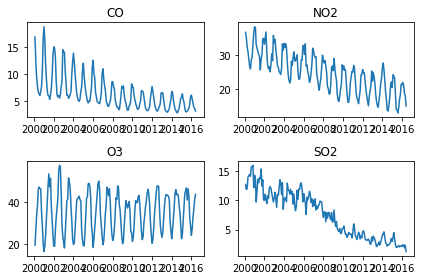

In [6]:
plt.subplot(221)
plt.plot(CO)
plt.title("CO")
plt.subplot(222)
plt.plot(NO_2)
plt.title("NO2")
plt.subplot(223)
plt.plot(O_3)
plt.title("O3")
plt.subplot(224)
plt.plot(SO_2)
plt.title("SO2")

plt.tight_layout()


## 檢測單根

[wiki](https://zh.wikipedia.org/wiki/迪基-福勒检验)

P value < 0.05 or 0.1 or 0.01 

Reject Null

Variable is Unit Root

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(df):
    # Rolling statics
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    
    # plot
    plt.plot(df, color='black', label='ori')
    plt.plot(rolmean, color='blue', label='rolmean')
    plt.plot(rolstd, color='red', label='rolstd')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    
    # Dickey-Fuller test
    print("result of test :")
    dftest = adfuller(df, autolag='AIC') # as default
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
        
    
    

    
    

result of test :
Test Statistic                  -2.167784
p-value                          0.218145
#Lags Used                      15.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


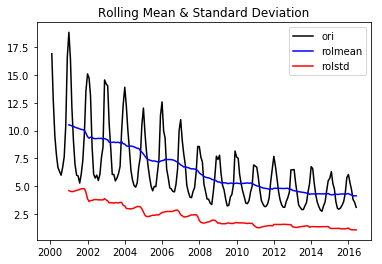

In [8]:
test_stationary(CO)

## 資料並非定態

### Try 取 Log

result of test :
Test Statistic                  -1.224011
p-value                          0.663183
#Lags Used                      15.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


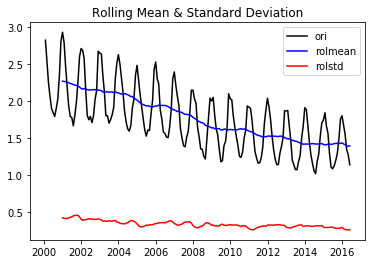

In [9]:
log_CO = np.log(CO)

test_stationary(log_CO)

## 更差

### 取移動平均差

result of test :
Test Statistic                  -3.866685
p-value                          0.002294
#Lags Used                      15.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


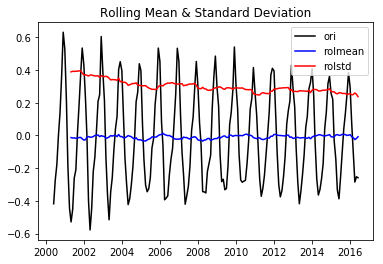

In [10]:
MA = log_CO.rolling(window=5).mean()
# plt.plot(log_CO, color='black')
# plt.plot(MA, color='red')
# 移動平均差

MA_diff = log_CO - MA
MA_diff = MA_diff.dropna()
test_stationary(MA_diff)


## 有定態了

In [11]:


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [12]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### ARIMA 參數選擇

[參考](https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3)

In [13]:
from statsmodels.tsa.statespace import sarimax
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sarimax.SARIMAX(MA_diff,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:70.15987966293218
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-98.1661626541769
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-447.2918540584668


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-470.44168933582387
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-461.255120570401
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-530.6519450830547
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-465.4889900626666


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-468.05333412559355
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-107.74714092216709
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-181.62900723914146
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-441.8822646981063
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-466.82559766683363
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-458.84594554686925
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-524.3249621397808
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-464.18504288052054
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-464.5639571737627
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-131.9323060103369
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-213.24951330294772
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-318.8314293897348


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-379.13063086901184
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-341.4516543675495
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-419.3073222700376
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-358.8632604678233
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-371.92929140748333
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-188.3099186130398
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-219.15294272179545
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-434.27467053777673
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-457.60294007864195
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-450.4931094210756
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-514.1840822054731
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-454.60626444052247
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-454.08334405014017
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-148.94881253646633
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-234.4872826238793
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-445.3346038777621
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-470.5139272514387
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-45

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-457.899449198775


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-462.09627114553314
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-214.01950021565915
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-231.47212113089432
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-364.33849197531265
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-409.15042670912794
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-377.0381555402132
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-450.3016206934211
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-393.32363881433537
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-402.44429054011766
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-210.35190615710871
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-227.76828383682005
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-432.3021796276874
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-457.4331341127884


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-445.81317567763847
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-513.114486604132
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-450.7549546156399
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-453.79325042278936


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-514.1840822054731

In [14]:
mod = sarimax.SARIMAX(log_CO,
                     order=(0,1,1),
                     seasonal_order=(1,0,1,12),
                     enforce_invertibility=False,
                     enforce_stationarity=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7606      0.052    -14.720      0.000      -0.862      -0.659
ar.S.L12       0.9733      0.003    309.111      0.000       0.967       0.979
ma.S.L12      -0.9250      0.101     -9.165      0.000      -1.123      -0.727
sigma2         0.0038      0.000      8.046      0.000       0.003       0.005


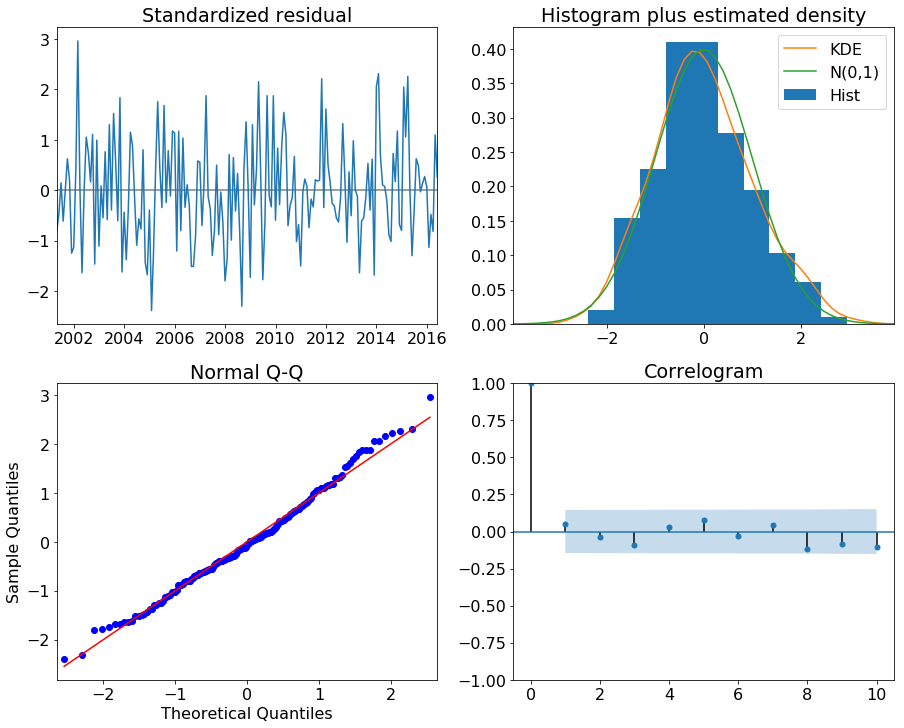

In [15]:
plt.rcParams.update({'font.size':16})
results.plot_diagnostics(figsize=(15, 12))
plt.savefig("../image.png")

左上角 原始

右上角 分布圖

左下角 配適曲線 紅線是預測 藍點是實際值

右下角 表示收斂 自相關



In [16]:
pred = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

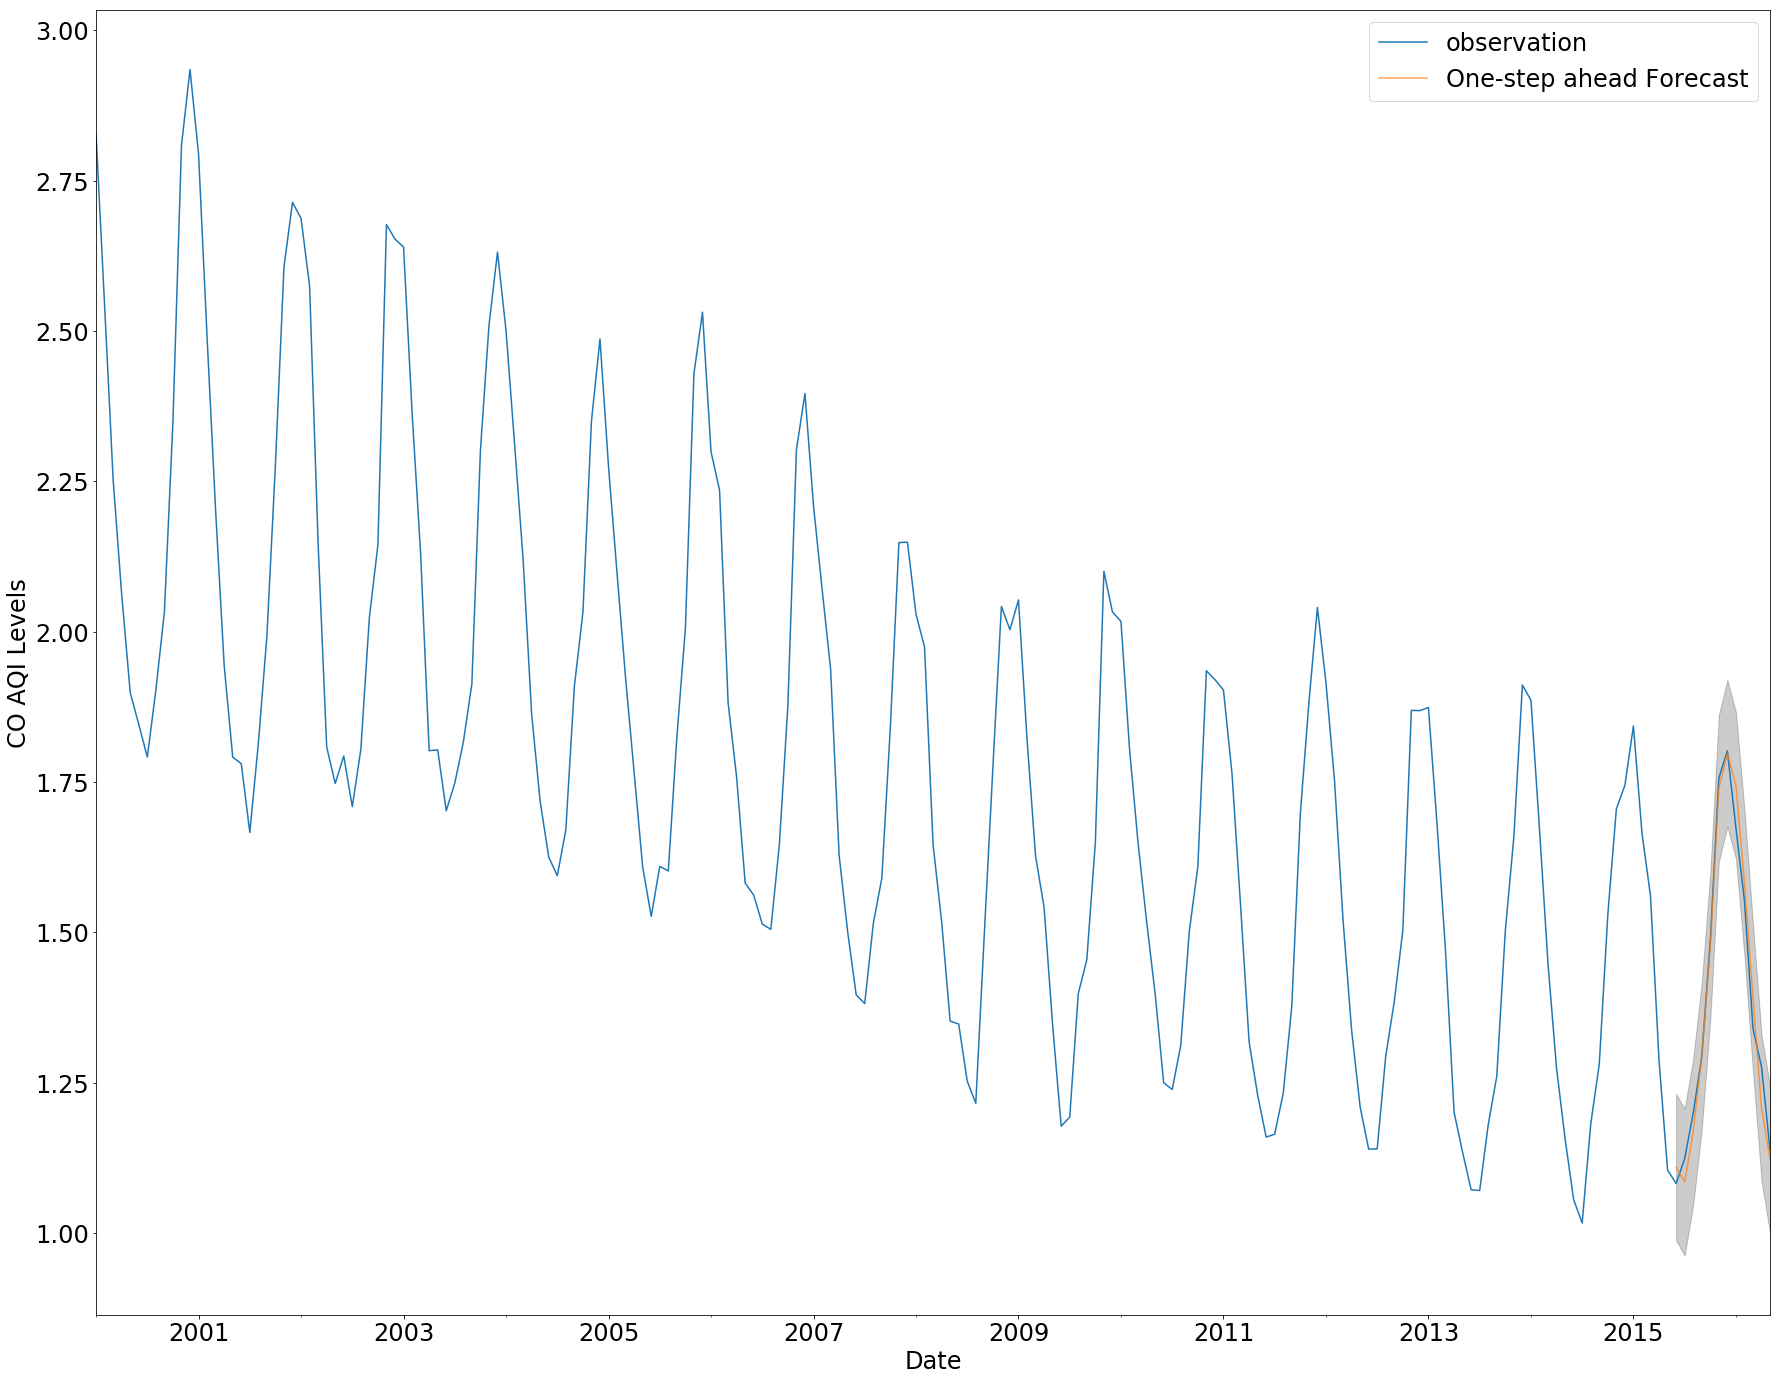

In [17]:
plt.figure(figsize=(30,24))
plt.rcParams.update({'font.size':24})
ax = log_CO['2000':].plot(label='observation')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.savefig("../Predict CO.png", bbox_inches='tight')

## 判斷模型

### MSE Mean Squire Error

In [18]:
CO_forcast = np.exp(pred.predicted_mean)
CO_forcast

Date Local
2015-06-30    3.032426
2015-07-31    2.958741
2015-08-31    3.218062
2015-09-30    3.649543
2015-10-31    4.379289
2015-11-30    5.694103
2015-12-31    6.036323
2016-01-31    5.721648
2016-02-29    4.867730
2016-03-31    4.017889
2016-04-30    3.345912
2016-05-31    3.071499
Freq: M, dtype: float64

In [19]:
CO_test = np.exp(log_CO['2015-06-30':])
CO_test

Date Local
2015-06-30    2.952043
2015-07-31    3.076002
2015-08-31    3.318218
2015-09-30    3.642277
2015-10-31    4.416361
2015-11-30    5.791546
2015-12-31    6.061546
2016-01-31    5.330937
2016-02-29    4.724196
2016-03-31    3.818433
2016-04-30    3.583012
2016-05-31    3.119816
Freq: M, Name: CO AQI, dtype: float64

In [20]:
mse = ((CO_forcast - CO_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse))

The Mean Squared Error of our forecasts is 0.026116005243046848


## Forecast

### 預測未來  12 個月

In [38]:
pred_uc = results.get_forecast(steps=12)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [39]:
pred_uc.predicted_mean

2016-06-30    1.072702
2016-07-31    1.058718
2016-08-31    1.131497
2016-09-30    1.245237
2016-10-31    1.423730
2016-11-30    1.677947
2016-12-31    1.730253
2017-01-31    1.672570
2017-02-28    1.533271
2017-03-31    1.351834
2017-04-30    1.192042
2017-05-31    1.090597
Freq: M, dtype: float64

In [40]:
pred_ci = pred_uc.conf_int()

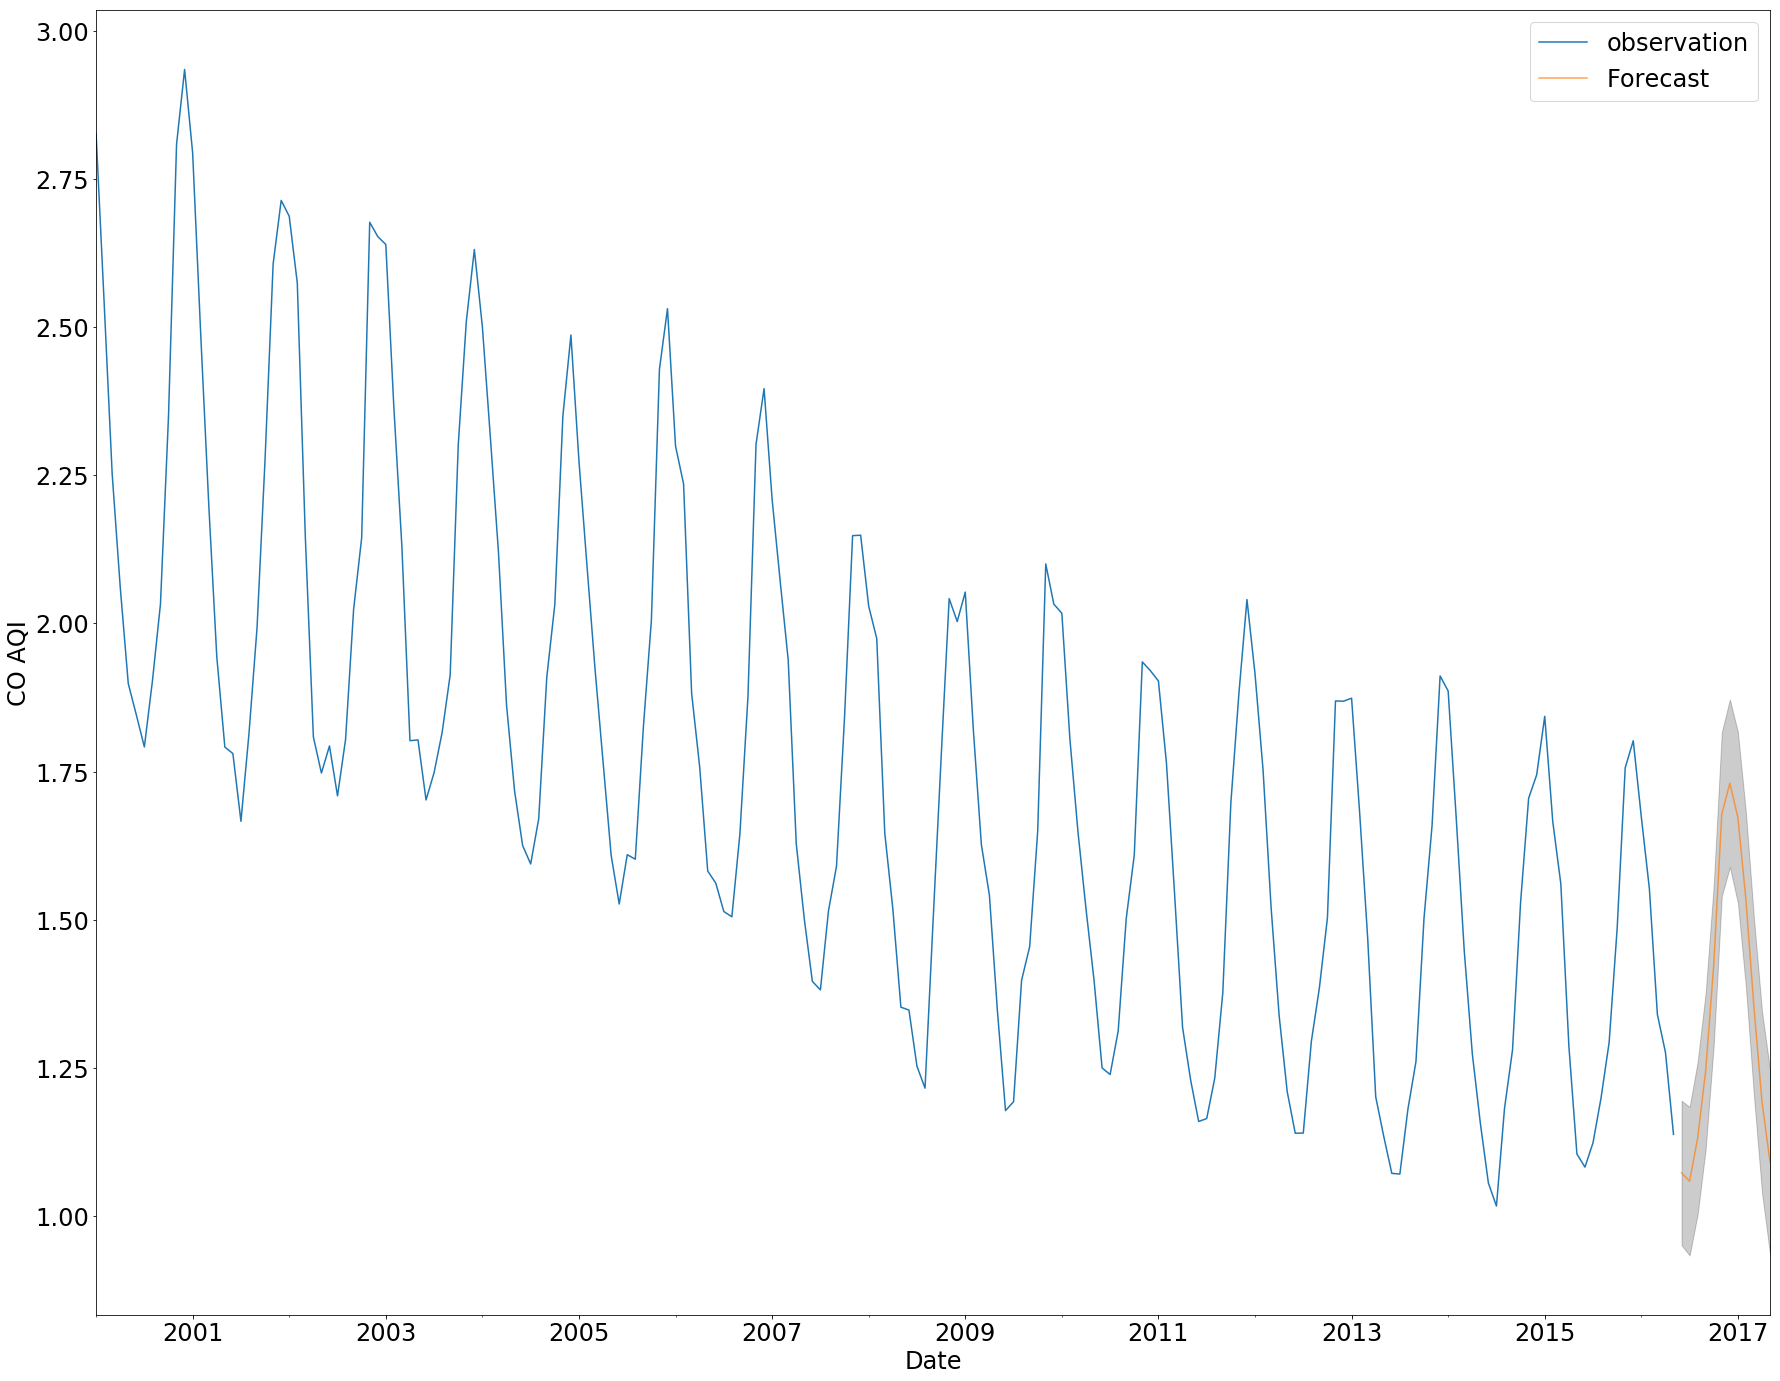

In [42]:
plt.figure(figsize=(30,24))
ax = log_CO['2000':].plot(label='observation')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7)


ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')
    

plt.legend()
plt.savefig("../forcast.png", bbox_inches='tight')